In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
def normalize(image):
  return image


def resize(image):
  im = torch.zeros(1, 32, 32)
  im[:, 2:30, 2:30] = image
  return im

In [60]:
train_dataset = MNIST(root="data", download=True, transform=Compose([ToTensor(), normalize, resize]))
test_dataset = MNIST(root="data", download=True, train=False, transform=Compose([ToTensor(), normalize, resize]))
train_data = DataLoader(train_dataset, batch_size=512)
test_data = DataLoader(test_dataset, batch_size=512)

In [61]:
image, label = train_dataset[10]

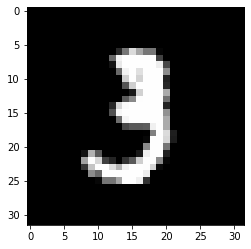

In [62]:
plt.imshow(image.numpy()[0], cmap="gray", vmin=0, vmax=1)
plt.show()

# Defining spiking dynamics

In [692]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0

def rate(x, p=torch.relu, t_rc = T_RC, t_ref = T_REF, V_th = V_TH):
  return torch.reciprocal(t_ref + t_rc * torch.log(1 + V_th / (p(x - V_th) + 1e-12)))

def soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH):
  return rate(x, p=lambda x: torch.nn.functional.softplus(x, beta=50), t_rc=t_rc, t_ref=t_ref, V_th=V_th)

In [693]:
soft_rate(torch.tensor(0.0))

tensor(1.7966)

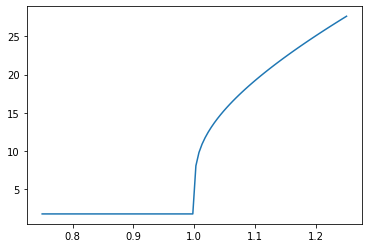

In [697]:

x = torch.linspace(0.75, 1.25, 100)
y = rate(x)
plt.plot(x, y)
plt.show()

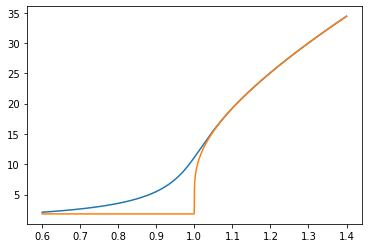

In [602]:
x = torch.linspace(0., 1.25, 100)
x = torch.linspace(0.6, 1.4, 1000)
y = soft_rate(x)
y2 = rate(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.show()

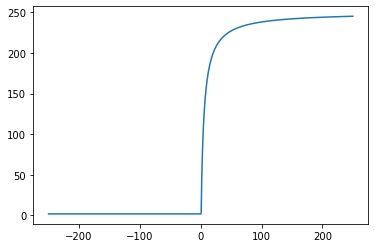

In [605]:
x = torch.linspace(-250, 250, 1000)
y = soft_rate(x)
plt.plot(x, y)
plt.show()

In [789]:
import math
# Use this a activation function
class SoftSpikeRate(nn.Module):
  def __init__(self, t_rc=0.02, t_ref=4e-3, V_th=1.0):
    super(SoftSpikeRate, self).__init__()
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)
  
  def forward(self, X):
    return soft_rate(X, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)
  
class SpikingLinear(nn.Module):
  def __init__(self, in_features, out_features, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0):
    super(SpikingLinear, self).__init__()
    # Initialize our weights
    self.weight = nn.Parameter(torch.empty(in_features, out_features))
    self.bias = nn.Parameter(torch.zeros(out_features))
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    with torch.no_grad():
      mean = 2/250/in_features
      std = 2/250/math.sqrt(in_features)
      nn.init.uniform_(self.weight, mean, mean+std)
      nn.init.constant_(self.bias, 1)

  def forward(self, X):
    return soft_rate(X @ self.weight + self.bias, t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)


class SpikingConv2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, *args, t_rc=0.02, t_ref=4e-3, V_th=1.0, bound=1.0, **kwargs):
    super().__init__(in_channels, out_channels, kernel_size, *args, **kwargs)
    self.t_rc = torch.tensor(t_rc)
    self.t_ref = torch.tensor(t_ref)
    self.V_th = torch.tensor(V_th)

    # with torch.no_grad():
    #   n = in_channels * kernel_size * kernel_size
    #   g = 2 * self.t_ref
    #   nn.init.normal_(self.weight, mean=1 * g / n, std=0.1 * g / math.sqrt(n))
    #   #bound = math.sqrt(3/n)
    #   #nn.init.uniform_(self.weight, a=-bound, b=bound)
    
  def forward(self, X):
    return soft_rate(super().forward(X), t_rc=self.t_rc, t_ref=self.t_ref, V_th=self.V_th)
    
"""
class SpikingCNN(nn.Module):
  def __init__(self) -> None:
    super(SpikingCNN, self).__init__()
    self.model = nn.Sequential(
      SpikingConv2d(1, 64, 3),
      SpikingConv2d(64, 64, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(64),
      SpikingConv2d(64, 128, 3),
      SpikingConv2d(128, 128, 3),
      nn.AvgPool2d(2, stride=2),
      #nn.BatchNorm2d(128),
      SpikingConv2d(128, 256, 3),
      nn.AvgPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      #nn.BatchNorm1d(256),
      SpikingLinear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X * 250)
"""

class BaselineDense(nn.Module):
  def __init__(self, in_features, out_features):
    super(BaselineDense, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(in_features, 2048),
      nn.ReLU(),
      nn.Linear(2048, 1024),
      nn.ReLU(),
      nn.Linear(1024, 512),
      nn.ReLU(),
      nn.Linear(512, out_features)
    )

  
  def forward(self, X):
    return F.softmax(self.model(X), dim=1)


class SpikingDense(nn.Module):
  def __init__(self, in_features, out_features):
    super(SpikingDense, self).__init__()

    self.model = nn.Sequential(
      SpikingLinear(in_features, 2048),
      SpikingLinear(2048, 1024),
      SpikingLinear(1024, 512),
      SpikingLinear(512, out_features)
    )
  
  def forward(self, X):
    return F.softmax(self.model(X * 20), dim=1)

    
"""
class BaselineCNN(nn.Module):
  def __init__(self) -> None:
    super(BaselineCNN, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(64),
      nn.Conv2d(64, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.BatchNorm2d(128),
      nn.Conv2d(128, 256, 3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      nn.BatchNorm1d(256),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)
"""


class BaselineCNN(nn.Module):
  def __init__(self) -> None:
    super(BaselineCNN, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3, stride=2),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3),
      nn.ReLU(),
      nn.Conv2d(64, 128, 3, stride=2),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 256, 3, stride=2),
      nn.ReLU(),
      nn.Flatten(start_dim=1),
      nn.Linear(256, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, X):
    return self.model(X)

class SpikingCNN(nn.Module):
  def __init__(self) -> None:
    super(SpikingCNN, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, 3, stride=2),
      SoftSpikeRate(),
      nn.Conv2d(64, 64, 3),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      #nn.BatchNorm2d(64),
      nn.Conv2d(64, 128, 3, stride=2),
      SoftSpikeRate(),
      nn.Conv2d(128, 128, 3),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      #nn.BatchNorm2d(128),
      nn.Conv2d(128, 256, 3, stride=2),
      SoftSpikeRate(),
      #nn.MaxPool2d(2, stride=2),
      nn.Flatten(start_dim=1),
      #nn.BatchNorm1d(256),
      nn.Linear(256, 10),
      SoftSpikeRate()
    )

  def forward(self, X):
    return F.softmax(self.model(X * 20), dim=1) 
  
  
class Simple(nn.Module):
  def __init__(self, in_features, out_features):
    super(Simple, self).__init__()
    self.model = nn.Linear(in_features, out_features)

  def forward(self, X):
    return F.softmax(self.model(X), dim=1)
  
  
class SimpleSNN(nn.Module):
  def __init__(self, in_features, out_features):
    super(SimpleSNN, self).__init__()
    self.model = nn.Linear(in_features, out_features)
    
    with torch.no_grad():
      n = in_features
      mean = 2 * 2/250/n
      std = 0.1 * 2/250/math.sqrt(n)
      nn.init.uniform_(self.model.weight, mean, mean+std)
      nn.init.constant_(self.model.bias, 1)
      
    self.fc = nn.Linear(out_features, out_features)

  def forward(self, X):
    a = self.model(X * 20)
    r = soft_rate(a)
    o = self.fc(r)
    return F.softmax(o, dim=1) #, r, a

1.6e-05 6.659644256269408e-05
tensor(1.4612e-05) tensor(4.1282e-05) 1.6e-05 5.0596442562694074e-05


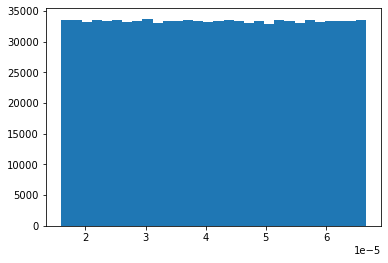

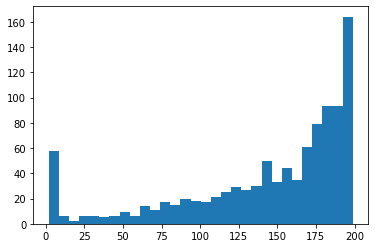

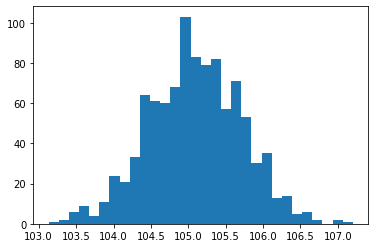

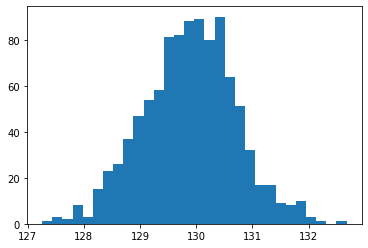

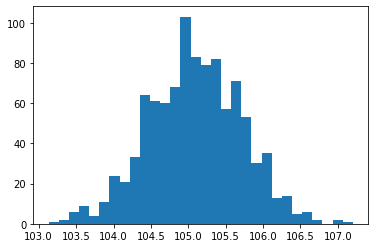

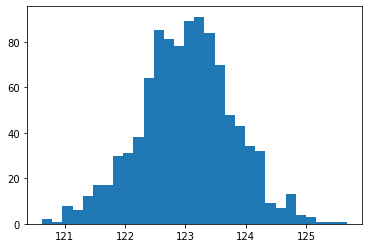

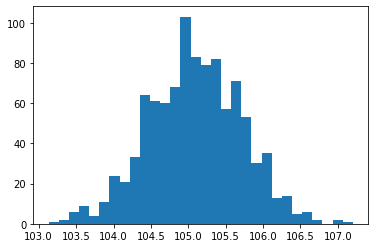

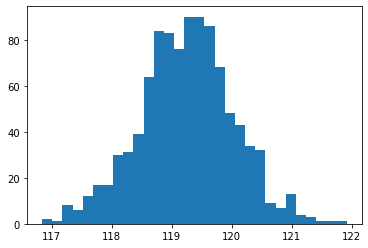

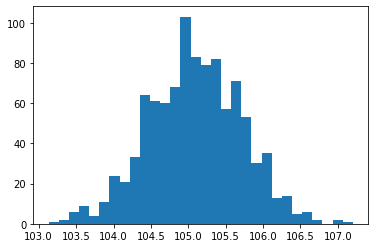

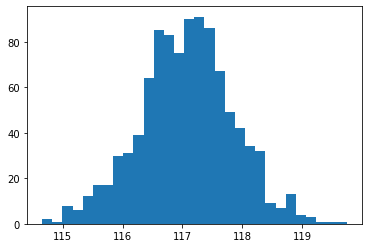

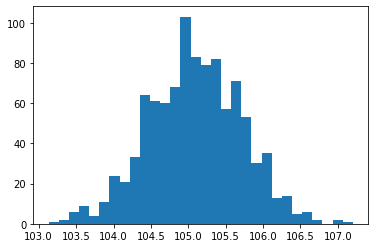

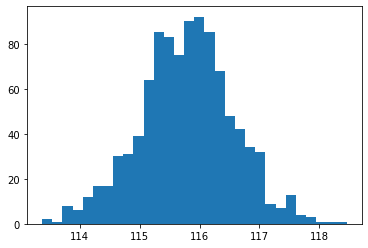

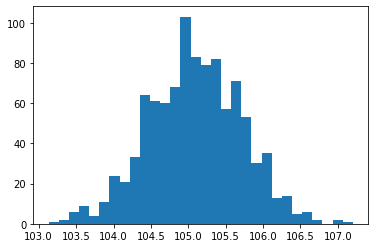

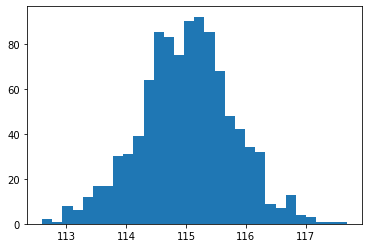

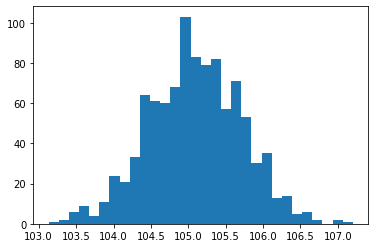

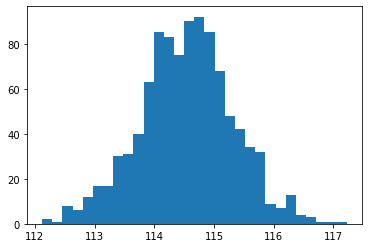

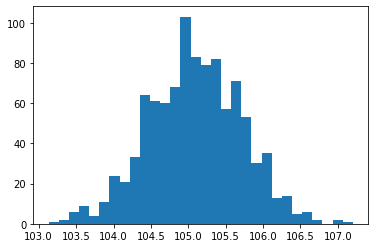

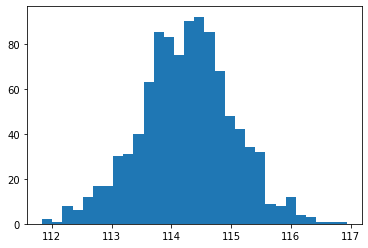

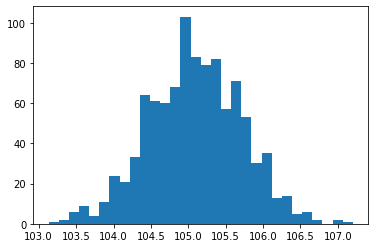

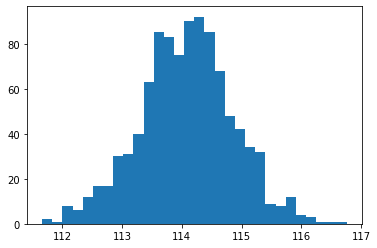

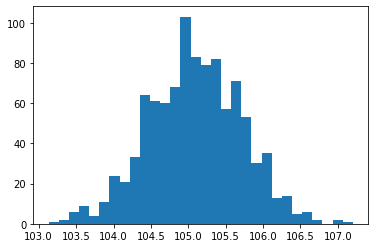

In [776]:
n = 1000
x = soft_rate(torch.rand(n) * 20)

mean = 2 * 2/250/n
std = 0.2 * 2/250/math.sqrt(n)
w = torch.rand(n, n) * std + mean

start_bound = mean
end_bound = mean + std

print(start_bound, end_bound)

print(w.std(), w.mean(), mean, std)
plt.hist(w.flatten().numpy(), bins=30)
plt.show()

for i in range(10):
  plt.hist(x.numpy(), bins=30)
  plt.show()

  x = soft_rate(w@x)

  plt.hist(z.numpy(), bins=30)
  plt.show()

In [813]:
torch.autograd.set_detect_anomaly(False)

In [636]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Explore weight initialization.
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))

for i, n in enumerate([100, 200, 500, 1000, 2000, 5000]):
  a = torch.rand(n) * 250
  mean = 2 * 2/250/n
  std = 0.1 * 2/250/math.sqrt(n)
  w = torch.randn(n, n) * std + mean
  o = a @ w

  ax = axs[i // ncols, i % ncols]

  ax.set_title(f"Mean: {o.mean():.02f}, std: {o.std():.02f}")
  ax.hist(o.numpy(), bins=30, density=True)
  #xs = torch.linspace(0.7, 1.3, 1000)
  #ax.plot(xs, soft_rate(xs))

fig.show()

In [582]:
image, label = train_dataset[0]
image = image.flatten()

test_model = SpikingDense(32*32, 10)
out1 = test_model.model[0](image[None, :])
print(out1.std(), out1.mean(), out1.min(), out1.max())
out2 = test_model.model[1](out1)
print(out2.std(), out2.mean(), out2.min(), out2.max())
out3 = test_model.model[2](out2)
print(out3.std(), out3.mean(), out3.min(), out3.max())
out4 = test_model.model[3](out3)
print(out4.std(), out4.mean(), out4.min(), out4.max())

#plt.hist(out1.detach().numpy(), bins=30)
#plt.show()

tensor(0.1751, grad_fn=<StdBackward>) tensor(-0.0071, grad_fn=<MeanBackward0>) tensor(-0.5867, grad_fn=<MinBackward1>) tensor(0.5983, grad_fn=<MaxBackward1>)
tensor(0.0063, grad_fn=<StdBackward>) tensor(1.7968, grad_fn=<MeanBackward0>) tensor(1.7966, grad_fn=<MinBackward1>) tensor(2.0686, grad_fn=<MaxBackward1>)
tensor(1.0426, grad_fn=<StdBackward>) tensor(-0.0368, grad_fn=<MeanBackward0>) tensor(-3.3856, grad_fn=<MinBackward1>) tensor(3.4756, grad_fn=<MaxBackward1>)
tensor(14.7482, grad_fn=<StdBackward>) tensor(7.9290, grad_fn=<MeanBackward0>) tensor(1.7966, grad_fn=<MinBackward1>) tensor(92.7146, grad_fn=<MaxBackward1>)


In [ ]:
n = 32*32
for bound in torch.linspace(250/math.sqrt(n), 1/n, 20):
  for skew in torch.linspace(250/math.sqrt(n), 1/n, 20):
    grad_norm = []
    for i in range(100):

      model = SimpleSNN(in_features=32*32, out_features=10).to(device)
      #model = Simple(in_features=32*32, out_features=10).to(device)
      criterion = nn.CrossEntropyLoss()
      image, label = train_dataset[0]
      image, label = image.to(device), torch.tensor(label).to(device)
      image, label = image[None, :], label[None]

      if model.model.weight.grad is not None:
        model.model.weight.grad.zero_()

      out = model(image.flatten(start_dim=1))
      loss = criterion(out, label)
      loss.backward()

      grad_norm.append(model.model.weight.grad.pow(2).sum().sqrt())

    print(f"bound: {bound}, grad: {torch.tensor(grad_norm).mean()}")

In [824]:
dense = True
#model = SpikingCNN().to(device)
#model = BaselineCNN().to(device)
#model = SpikingDense(in_features=32*32, out_features=10).to(device)
#model = BaselineDense(in_features=32*32, out_features=10).to(device)
#model = Simple(in_features=32*32, out_features=10).to(device)
model = SimpleSNN(in_features=32*32, out_features=10).to(device)

In [825]:
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [826]:
loss_history = []
num_epochs = 10

In [827]:
for epoch in range(num_epochs):
  # Train
  model.train()
  train_data_tqdm = tqdm(train_data)
  for i, (images, labels) in enumerate(train_data_tqdm):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    if dense:
      images = images.flatten(start_dim=1)
    preds = model(images)
    loss = criterion(preds, labels)
    loss_history.append(loss.item())
    loss.backward()
    
    #grad_size = model.model.weight.grad.pow(2).sum().mean()
    #print(grad_size)
    
    optimizer.step()
    #if i % 10 == 0:
    train_data_tqdm.set_description("Training - Epoch: {}, Loss: {:.4f}".format(epoch + 1, loss.item()))
  
  # Test
  model.eval()
  test_data_tqdm = tqdm(test_data)
  test_data_tqdm.set_description("Testing...")
  num_correct = 0
  for (images, labels) in test_data_tqdm:
    images, labels = images.to(device), labels.to(device)
    if dense:
      images = images.flatten(start_dim=1)
    pred_labels = model(images).argmax(dim=1)
    num_correct += torch.sum(pred_labels == labels).item()
    
  accuracy = num_correct / len(test_dataset) * 100
  print(f"Accuracy: {accuracy:.2f}%")

plt.plot(loss_history)
plt.show()

Testing...: 100%|██████████| 20/20 [00:00<00:00, 27.87it/s]


Accuracy: 11.35%


Training - Epoch: 2, Loss: 2.3537:  28%|██▊       | 33/118 [00:01<00:03, 25.39it/s]


KeyboardInterrupt: 

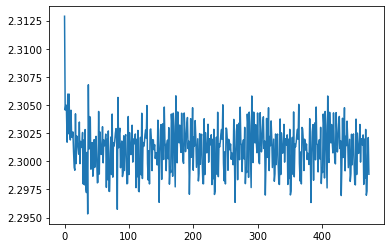

In [809]:
plt.plot(loss_history)
plt.show()

# Alpha filter

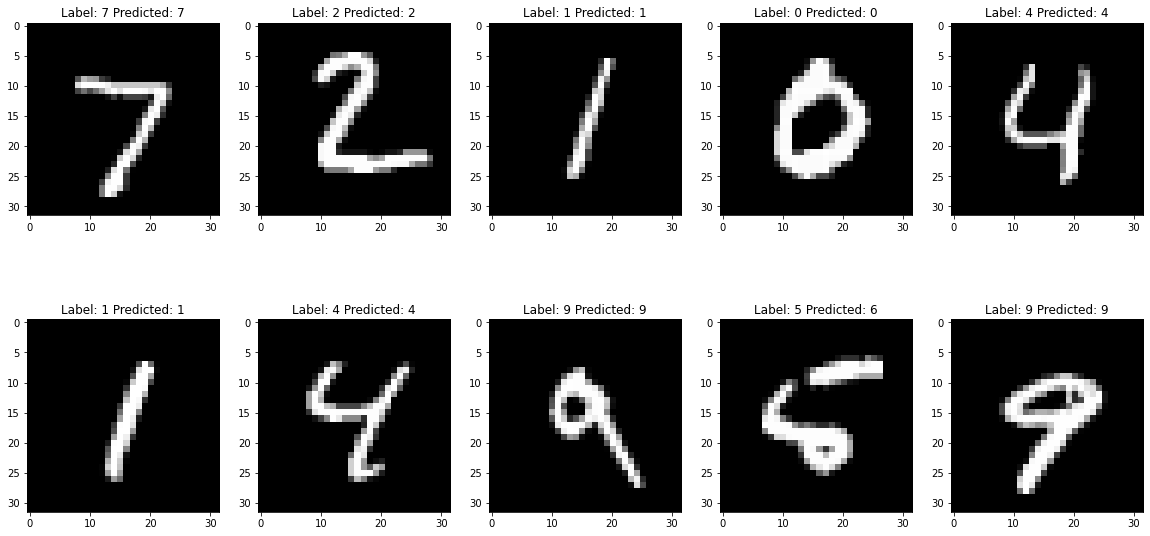

In [166]:
model.eval()
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))

for row in range(rows):
  for col in range(cols):
    image, label = test_dataset[row * cols + col]
    image = image[None, :].to(device)
    
    out = model(image.flatten(start_dim=1) if dense else image)

    axs[row][col].set_title("Label: {} Predicted: {}".format(label, out.argmax().item()))
    axs[row][col].imshow(image[0][0].cpu().numpy(), cmap="gray")

In [525]:
def alpha_filter(t, t_s=0.003):
  return t / t_s * torch.exp(-t/t_s)

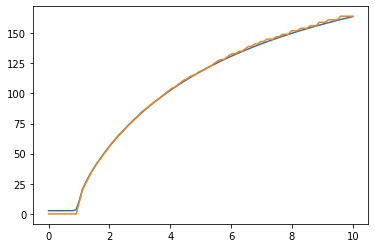

In [281]:
input_current = torch.linspace(0.0, 10, 100)
response = soft_rate(input_current)

secs = 1
dt = 1e-4
steps = int(secs / dt)
v = torch.zeros(100)
timeouts = torch.zeros(100)
vs = []
spikes = torch.zeros(steps, 100)
for i in range(steps):
  timeouts[timeouts > 0] -= dt
  dv = (-v + input_current) / T_RC
  v[timeouts <= 0] += dt * dv[timeouts <= 0]

  # Reset spikes
  spikes[i, v > 1] = 1
  timeouts[v > 1] = T_REF
  v[v > 1] = 0
  
  vs.append(v.clone())

vs = torch.stack(vs)
plt.plot(input_current, response)
plt.plot(input_current, spikes.sum(dim=0))
plt.show()

In [405]:
loss =  criterion(out, torch.tensor([3]))

In [406]:
loss.backward()

In [407]:
model.model[-2].A.grad

AttributeError: 'Linear' object has no attribute 'A'

In [475]:
torch.softmax(SpikeLayer(256, 10)(SpikeLayer(32*32, 256)(image.view(-1, 32*32))))

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype)
 * (Tensor input, name dim, *, torch.dtype dtype)
